## Environment Setup

In [1]:
#!pip install openpyxl
#!pip install geopandas 
#!pip install folium

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None

import geopandas as gpd
import folium
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.insert (0, './_functions_/')
from functions_electric_cars import *

## Datasets

In [3]:
gas_stations_state = pd.read_csv("./clean_data/gas_stations_state.csv")

ev_stations_state = pd.read_csv('clean_data/population_states_stations_2025.csv')

complete = ev_stations_state.merge(gas_stations_state, on = 'state', how="left")

complete.head(10)


state  inhabitants     area  population_density  \
0       Baden-Württemberg     11280257  3574785                 316   
1                  Bayern     13369393  7054158                 190   
2                  Berlin      3755251    89112                4214   
3             Brandenburg      2573135  2965438                  87   
4                  Bremen       684864    41961                1632   
5                 Hamburg      1892122    75509                2506   
6                  Hessen      6391360  2111562                 303   
7  Mecklenburg-Vorpommern      1628378  2329490                  70   
8           Niedersachsen      8140242  4770990                 171   
9     Nordrhein-Westfalen     18139116  3411272                 532   

   number_of_charging_points  number_fast_charging_stations  \
0                      93695                          14271   
1                     111983                          19649   
2                      18854                           2325   
3                      12340                           2897   
4                       3969                            537   
5                      14077                           2157   
6                      41655                           7504   
7                       6887                           1677   
8                      54124                          11727   
9                     101969                          17163   

   number_regular_charging_stations  number_of_electric_cars  number_cars  \
0                             79424                   447516      8662899   
1                             92334                   508858     10907517   
2                             16529                    77486      1492346   
3                              9443                    57883      1891574   
4                              3432                    15280       349764   
5                             11920                    63864       955424   
6                             34151                   247801      4746596   
7                              5210                    26345      1124068   
8                             42397                   271977      6144748   
9                             84806                   654721     12737736   

   number_non_electric_cars  cars_per_ev_station  number_of_gas_stations  
0                   8215383             4.776306                   1.132  
1                  10398659             4.544065                   1.281  
2                   1414860             4.109791                 109.000  
3                   1833691             4.690681                 113.000  
4                    334484             3.849836                  25.000  
5                    891560             4.536762                 103.000  
6                   4498795             5.948890                 522.000  
7                   1097723             3.825323                 102.000  
8                   5872771             5.025072                 839.000  
9                  12083015             6.420785                   1.179

In [4]:
# Load GeoJSON file
geojson_url = "https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/main/2_bundeslaender/2_hoch.geo.json"
germany_states = gpd.read_file(geojson_url)

# Display the first few rows
germany_states.head(5)



id               name   type  \
0  DE-BW  Baden-Württemberg  State   
1  DE-BY             Bayern  State   
2  DE-BE             Berlin  State   
3  DE-BB        Brandenburg  State   
4  DE-HB             Bremen  State   

                                            geometry  
0  MULTIPOLYGON (((9.65046 49.77634, 9.65097 49.7...  
1  POLYGON ((10.13386 50.55, 10.1398 50.54252, 10...  
2  POLYGON ((13.16181 52.59442, 13.1801 52.59416,...  
3  POLYGON ((13.87951 53.50107, 13.87927 53.49908...  
4  POLYGON ((8.98545 53.12822, 8.97316 53.12799, ...

In [5]:
# Merge the two datasets
# Ensure the state names match between your dataset and the GeoJSON
complete['state'] = complete['state'].str.strip()

# Merge dataset with GeoJSON
germany_states = germany_states.merge(complete, left_on="name", right_on="state", how="left")



Renames the states to match the names of the map

In [6]:
state_name_mapping = {
    "Baden-Württemberg": "Baden-Wurttemberg",
    "Bayern": "Bavaria",
    "Berlin": "Berlin",
    "Brandenburg": "Brandenburg",
    "Bremen": "Bremen",
    "Hamburg": "Hamburg",
    "Hessen": "Hesse",
    "Mecklenburg-Vorpommern": "Mecklenburg-Western Pomerania",
    "Niedersachsen": "Lower Saxony",
    "Nordrhein-Westfalen": "North Rhine-Westphalia",
    "Rheinland-Pfalz": "Rhineland-Palatinate",
    "Saarland": "Saarland",
    "Sachsen": "Saxony",
    "Sachsen-Anhalt": "Saxony-Anhalt",
    "Schleswig-Holstein": "Schleswig-Holstein",
    "Thüringen": "Thuringia"
}

In [7]:
germany_states['state_abbreviation'] = germany_states['state'].map(german_states_abbreviations)


In [8]:
germany_states["state"] = germany_states["state"].replace(state_name_mapping)
germany_states["name"] = germany_states["name"].replace(state_name_mapping)

In [9]:
germany_states.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   id                                16 non-null     object  
 1   name                              16 non-null     object  
 2   type                              16 non-null     object  
 3   geometry                          16 non-null     geometry
 4   state                             16 non-null     object  
 5   inhabitants                       16 non-null     int64   
 6   area                              16 non-null     int64   
 7   population_density                16 non-null     int64   
 8   number_of_charging_points         16 non-null     int64   
 9   number_fast_charging_stations     16 non-null     int64   
 10  number_regular_charging_stations  16 non-null     int64   
 11  number_of_electric_cars           16 non-null     in

## Add new columns with

In [10]:
germany_states ['ev_per_stations'] = germany_states ['number_of_electric_cars'] / germany_states ['number_of_charging_points']

In [11]:
germany_states ['ev_per_population'] = germany_states ['number_of_electric_cars'] / germany_states ['inhabitants']

In [12]:
germany_states ['non_ev_per_gas_station'] = germany_states ['number_non_electric_cars'] / germany_states ['number_of_gas_stations']

In [13]:

# Create a Folium map
m = folium.Map(location=[51.1657, 10.4515], zoom_start=6, tiles="CartoDB positron")

# Add the Choropleth Layer
folium.Choropleth(
    geo_data=germany_states,
    name="choropleth",
    data=germany_states,
    columns=['state', 'number_of_charging_points'],
     key_on="feature.properties.name",
    fill_color="Greens",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="EV Charging Stations Density"
).add_to(m)

# Add state borders
folium.GeoJson(
    germany_states,
    name="State Borders",
    style_function=lambda x: {
        "fillColor": "transparent",
        "color": "black",
        "weight": 1,
    }
).add_to(m)

# Show the map
m


In [14]:

# Create a Folium map
m = folium.Map(location=[51.1657, 10.4515], zoom_start=6, tiles="CartoDB positron")

# Add the Choropleth Layer
folium.Choropleth(
    geo_data=germany_states,
    name="choropleth",
    data=germany_states,
    columns=['state', 'number_of_gas_stations'],
     key_on="feature.properties.name",
    fill_color="Greens",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Gas Stations Density"
).add_to(m)

# Add state borders
folium.GeoJson(
    germany_states,
    name="State Borders",
    style_function=lambda x: {
        "fillColor": "transparent",
        "color": "black",
        "weight": 1,
    }
).add_to(m)

# Show the map
m


In [15]:

# Create a Folium map
m = folium.Map(location=[51.1657, 10.4515], zoom_start=6, tiles="CartoDB positron")

# Add the Choropleth Layer
folium.Choropleth(
    geo_data=germany_states,
    name="choropleth",
    data=germany_states,
    columns=['state', 'number_of_electric_cars'],
     key_on="feature.properties.name",
    fill_color= "Greens",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Electric-Cars Density"
).add_to(m)

# Add state borders
folium.GeoJson(
    germany_states,
    name="State Borders",
    style_function=lambda x: {
        "fillColor": "transparent",
        "color": "black",
        "weight": 1,
    }
).add_to(m)

# Show the map
m


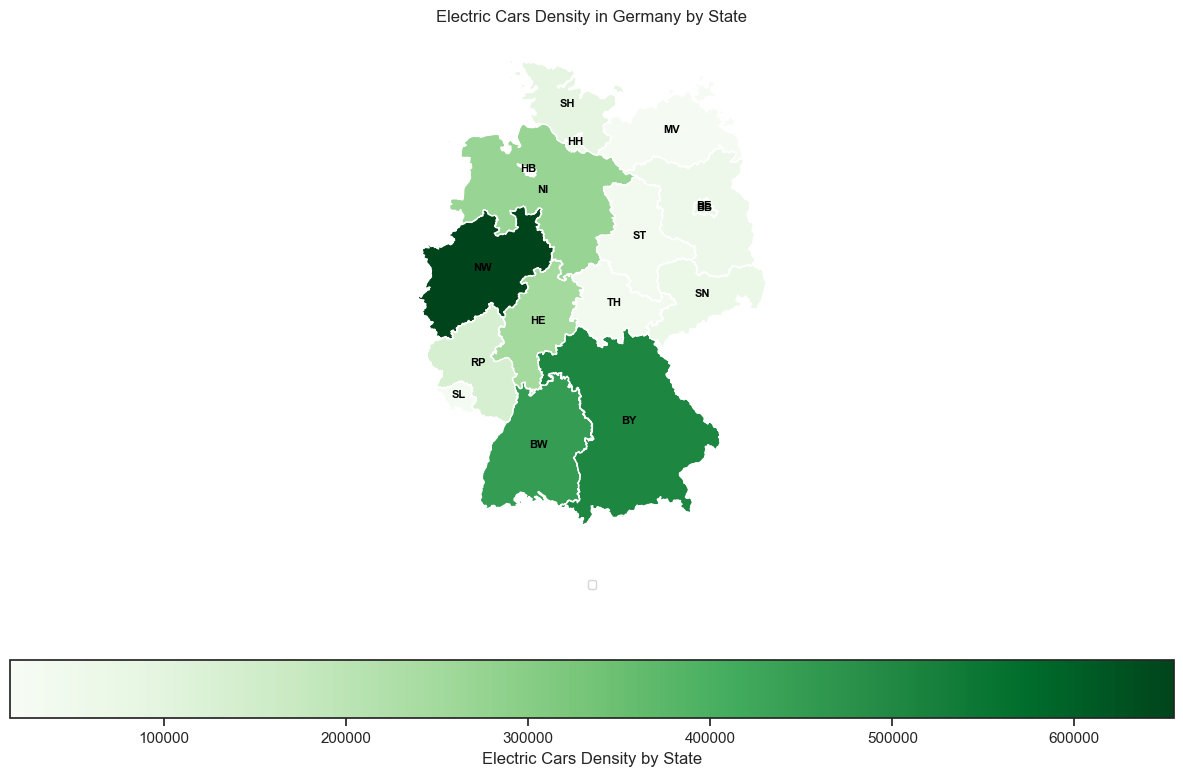

In [16]:
# Step 1: Plot the map
fig, ax = plt.subplots(figsize=(12, 8))

# Use a colormap for the 'number_of_electric_cars' (e.g., 'Greens')
germany_states.plot(column='number_of_electric_cars', ax=ax, legend=True,
         cmap='Greens', legend_kwds={'label': "Electric Cars Density by State",
                      'orientation': "horizontal"})


# Step 2: Add labels with the exact percentage of fast stations
for idx, row in germany_states.iterrows():    
   # Get the centroid of the state
    centroid = row["geometry"].centroid
    centroid_x, centroid_y = centroid.x, centroid.y

    # Check if the centroid has already been used
    if (row['state'] == 'Brandenburg'):
        # If used, adjust the position (move slightly south)
        # This moves the annotation to a point between the center and the southernmost point
        south_point = row["geometry"].bounds[1]  # southernmost y-coordinate
        adjusted_y = (centroid_y + south_point) / 2  # midpoint between center and south
        adjusted_x = centroid_x  # keep x the same
    else:
        # If not used, use the original centroid
        adjusted_x, adjusted_y = centroid_x, centroid_y  
    # Annotate the plot
    ax.annotate(
        row['state_abbreviation'],
        xy=(row["geometry"].centroid.x, row["geometry"].centroid.y),
        ha="center",
        fontsize=8,
        color="black",
        weight="bold"
    )


# Step 4: Add a title
plt.title("Electric Cars Density in Germany by State")

# Step 5: Adjust the legend size and position
# Use 'fontsize' to reduce legend text size and 'bbox_to_anchor' to adjust position
plt.legend(fontsize=8, bbox_to_anchor=(0.5, -0.05), loc="upper center", ncol=1)

# Optional: Hide axes if not needed
plt.axis('off')


# Step 6: Show the plot
plt.tight_layout()
plt.show()

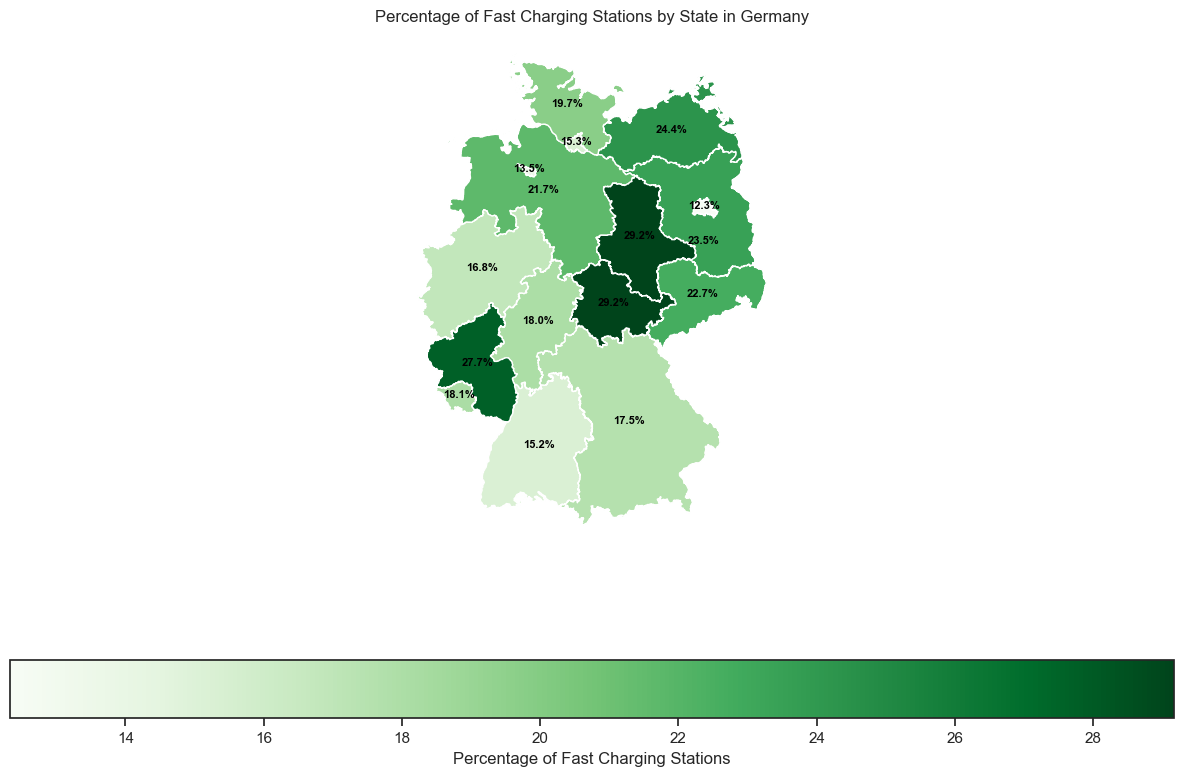

In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Step 1: Calculate the percentage of fast stations
germany_states['fast_percentage'] = (germany_states['number_fast_charging_stations'] / 
                           (germany_states['number_fast_charging_stations'] + germany_states['number_regular_charging_stations'])) * 100

# Step 2: Plot the map
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the map with color scale based on the fast_percentage
germany_states.plot(ax=ax, column='fast_percentage', cmap='Greens', legend=True,
         legend_kwds={'label': "Percentage of Fast Charging Stations",
                      'orientation': "horizontal"})

# Step 3: Add labels with the exact percentage of fast stations
for idx, row in germany_states.iterrows():
    # Get the centroid of the state
    centroid = row["geometry"].centroid
    centroid_x, centroid_y = centroid.x, centroid.y

    # Check if the centroid has already been used
    if (row['state'] == 'Brandenburg'):
        # If used, adjust the position (move slightly south)
        # This moves the annotation to a point between the center and the southernmost point
        south_point = row["geometry"].bounds[1]  # southernmost y-coordinate
        adjusted_y = (centroid_y + south_point) / 2  # midpoint between center and south
        adjusted_x = centroid_x  # keep x the same
    else:
        # If not used, use the original centroid
        adjusted_x, adjusted_y = centroid_x, centroid_y

    
    # Annotate the plot
    ax.annotate(
        f"{row['fast_percentage']:.1f}%",
        xy=(adjusted_x, adjusted_y),
        ha="center",
        fontsize=8,
        color="black",
        weight="bold"
    )

# Title and formatting
plt.title("Percentage of Fast Charging Stations by State in Germany")
plt.axis("off")  # Optionally hide axis
plt.tight_layout()
plt.show()


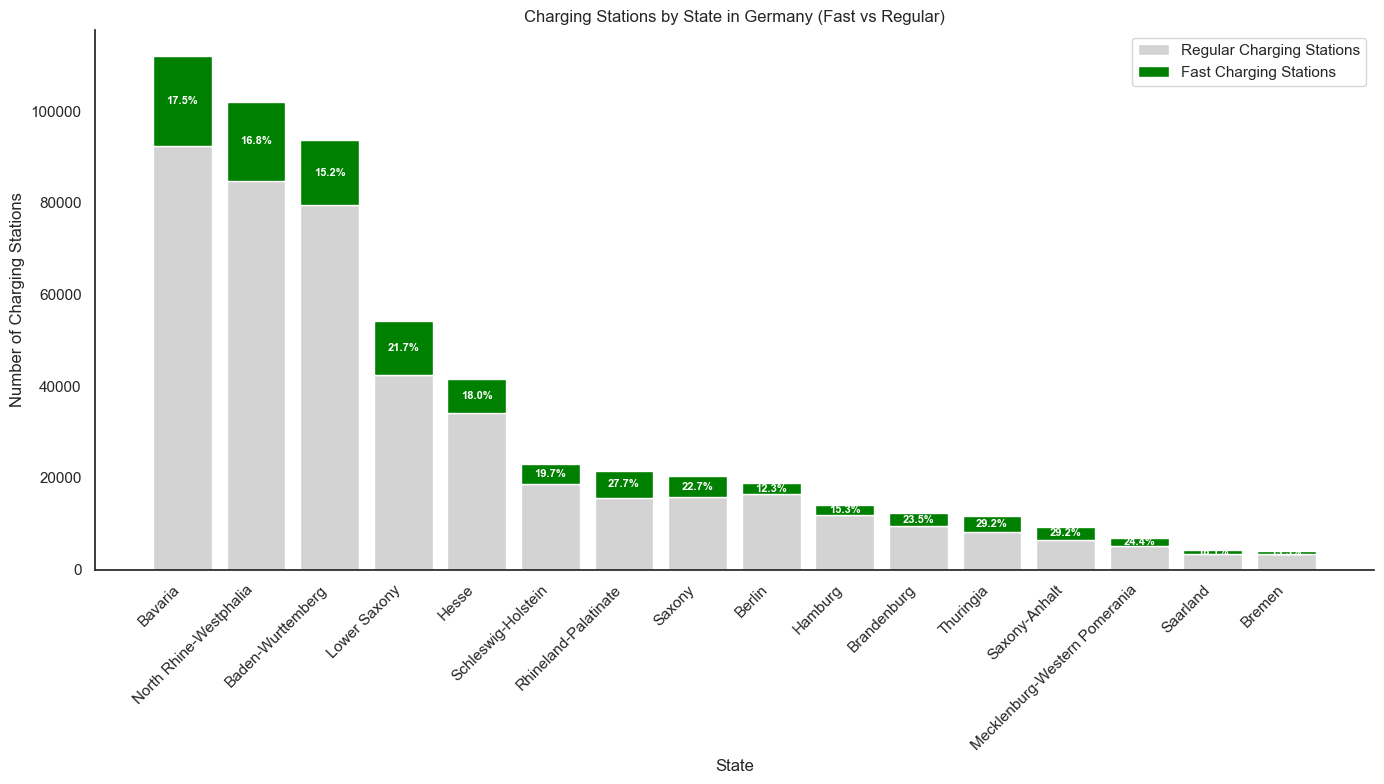

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Prepare the data
germany_states_sorted = germany_states.sort_values(by='number_of_charging_points', ascending=False)

states = germany_states_sorted['state']
fast = germany_states_sorted['number_fast_charging_stations']
regular = germany_states_sorted['number_regular_charging_stations']

# Step 2: Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(14, 8))

ax.bar(states, regular, label='Regular Charging Stations', color='lightgray')
ax.bar(states, fast, bottom=regular, label='Fast Charging Stations', color='green')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Step 3: Annotate each bar with the fast percentage
for idx, (f, r) in enumerate(zip(fast, regular)):
    total = f + r
    percentage = (f / total) * 100 if total > 0 else 0
    ax.text(idx, r + f/2, f"{percentage:.1f}%", ha='center', va='center', fontsize=8, color='white', weight='bold')

# Formatting
plt.title("Charging Stations by State in Germany (Fast vs Regular)")
plt.xlabel("State")
plt.ylabel("Number of Charging Stations")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()

plt.show()
